# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Run results

In [1]:
!python result_blocking.py

Using device: cuda
/home/jovyan/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-01-30 16:18:44.324265: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF

## Import libraries

In [16]:
import os

while 'model' not in os.listdir():
    os.chdir('..')

In [17]:
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from model.utils import load_data
from model.Blocking import get_blocking_metrics, merge_true_matches
import src.blocking.result_blocking as result_blocking
import src.import_data as import_data

In [18]:
print('Available models:')
print(result_blocking.MODELS)
print()
print('Available datasets:')
print(result_blocking.DATA_NAMES)

Available models:
['sentence-transformers/allenai-specter', 'all-distilroberta-v1', 'all-mpnet-base-v2', 'multi-qa-mpnet-base-dot-v1']

Available datasets:
['fodors-zagats', 'amazon-google', 'abt-buy']


## Amazon-Google

In [19]:
data_name = 'amazon-google'

table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 



In [38]:
preds = {}
results_dict = {}
for data_name in result_blocking.DATA_NAMES:
    results_dict[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    all_true_matches = merge_true_matches(X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test)
    for model_name in result_blocking.MODELS:
        results_dict[data_name][model_name] = {}
        for order_cols in result_blocking.LOAD_OPTIONS['order_cols']:
            results_dict[data_name][model_name][order_cols] = {}
            for remove_col_names in result_blocking.LOAD_OPTIONS['remove_col_names']:
                results_dict[data_name][model_name][order_cols][remove_col_names] = {}
                for K in result_blocking.K_s:
                    dir_name = f'{data_name}-blocking/{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}-K_{K}'
                    pairs = []
                    with open(os.path.join('results', dir_name, 'pairs.txt'), 'r') as f:
                        for line in f:
                            pairs.append([int(x) for x in line.strip().split(',')])
                
                    reduction_ratio, recall, f1 = get_blocking_metrics(pairs, all_true_matches, len(table_a_serialized), len(table_b_serialized))
                    
                    results_dict[data_name][model_name][order_cols][remove_col_names][K] = {
                        'reduction_ratio': reduction_ratio,
                        'recall': recall,
                        'f1': f1
                    }
                    

Table A columns:
  column_name              data_example
1        addr  '435 s. la cienega blv.'
2        city             'los angeles'
3       phone              310/246-1501
4        type                  american 

Table B columns:
  column_name           data_example
1        addr  '10801 w. pico blvd.'
2        city              'west la'
3       phone           310-475-3585
4        type               american 

Serialized entities 

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 

Table A columns:
   column_name                                       data_example
1  description  Sony Turntable - PSLX350H/ Belt Drive System/ ...
2        price                                                

In [39]:
for data_name, models in results_dict.items():
    best_f1 = 0
    best_option = None
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                for K, metrics in metrics.items():
                    if metrics['f1'] > best_f1:
                        best_f1 = metrics['f1']
                        best_option = (model_name, order_cols, remove_col_names, K)
    print(f"Dataset: {data_name}, Best F1 Score: {best_f1}, Options: {best_option}")

Dataset: fodors-zagats, Best F1 Score: 0.9865028278284746, Options: ('all-distilroberta-v1', True, True, 5)
Dataset: amazon-google, Best F1 Score: 0.9874879867606273, Options: ('multi-qa-mpnet-base-dot-v1', False, False, 14)
Dataset: abt-buy, Best F1 Score: 0.9916068352802445, Options: ('multi-qa-mpnet-base-dot-v1', False, False, 8)


In [40]:
for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                for K, metrics in metrics.items():
                    print(f"Dataset: {data_name}, Model: {model_name}, Order Cols: {order_cols}, Remove Col Names: {remove_col_names}, K: {K}")
                    print(f"Reduction Ratio: {metrics['reduction_ratio']}, Recall: {metrics['recall']}, F1: {metrics['f1']}")
                    print()

Dataset: fodors-zagats, Model: sentence-transformers/allenai-specter, Order Cols: True, Remove Col Names: True, K: 5
Reduction Ratio: 0.9719991157615504, Recall: 1.0, F1: 0.9858007622748673

Dataset: fodors-zagats, Model: sentence-transformers/allenai-specter, Order Cols: True, Remove Col Names: True, K: 8
Reduction Ratio: 0.955686050004818, Recall: 1.0, F1: 0.9773409694285681

Dataset: fodors-zagats, Model: sentence-transformers/allenai-specter, Order Cols: True, Remove Col Names: True, K: 11
Reduction Ratio: 0.9399227991815127, Recall: 1.0, F1: 0.9690311383299196

Dataset: fodors-zagats, Model: sentence-transformers/allenai-specter, Order Cols: True, Remove Col Names: True, K: 14
Reduction Ratio: 0.9241595483582072, Recall: 1.0, F1: 0.9605851543306252

Dataset: fodors-zagats, Model: sentence-transformers/allenai-specter, Order Cols: True, Remove Col Names: True, K: 17
Reduction Ratio: 0.9088044075885797, Recall: 1.0, F1: 0.9522237102717983

Dataset: fodors-zagats, Model: sentence-tra

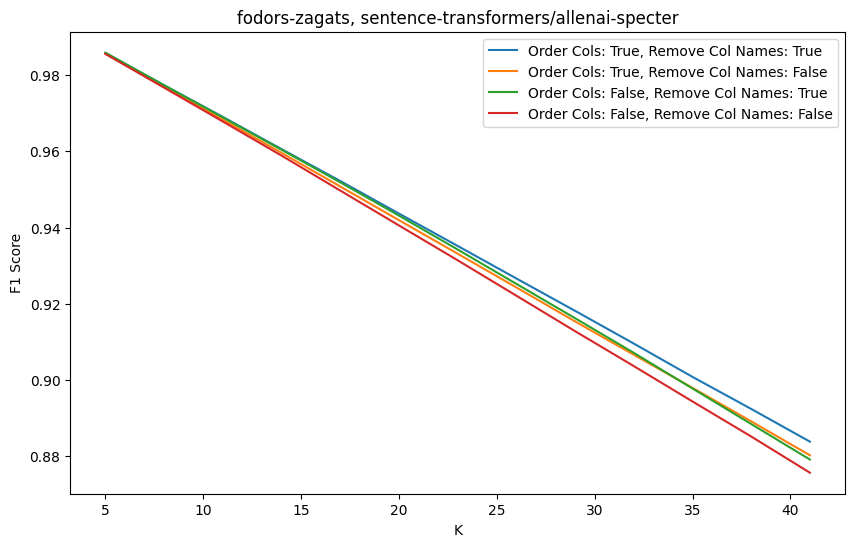

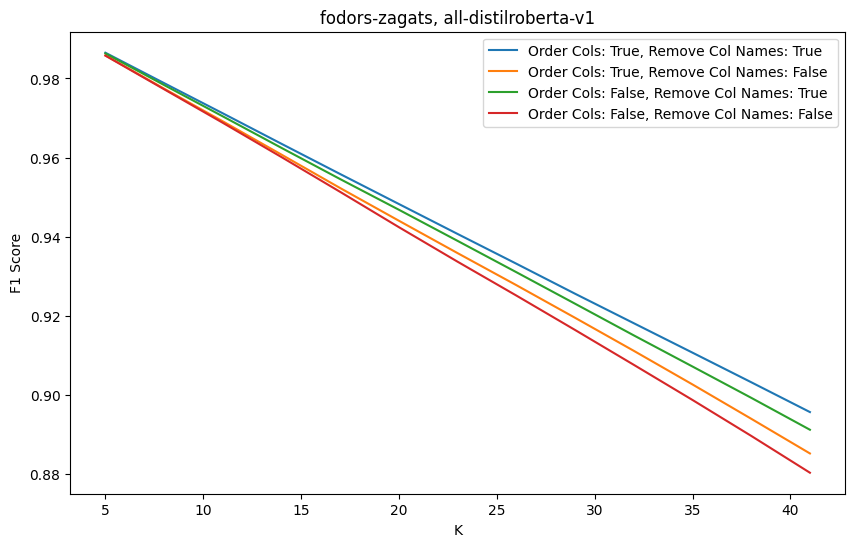

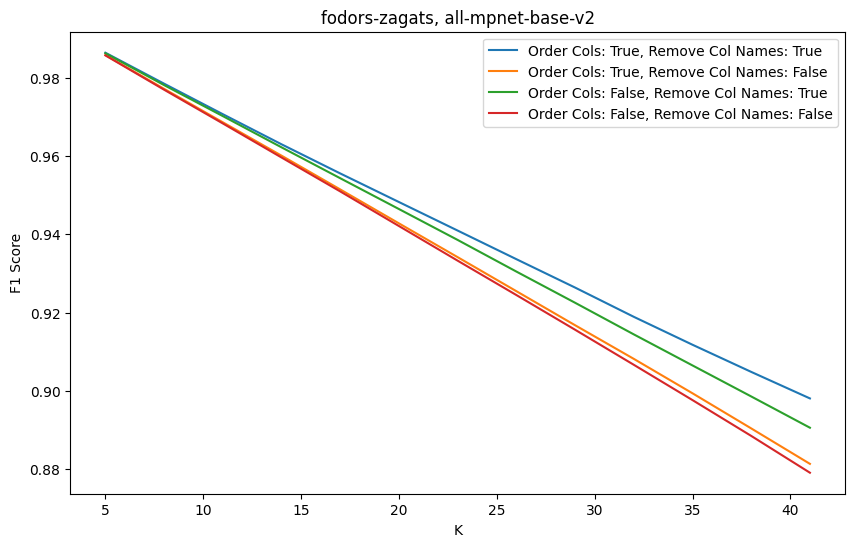

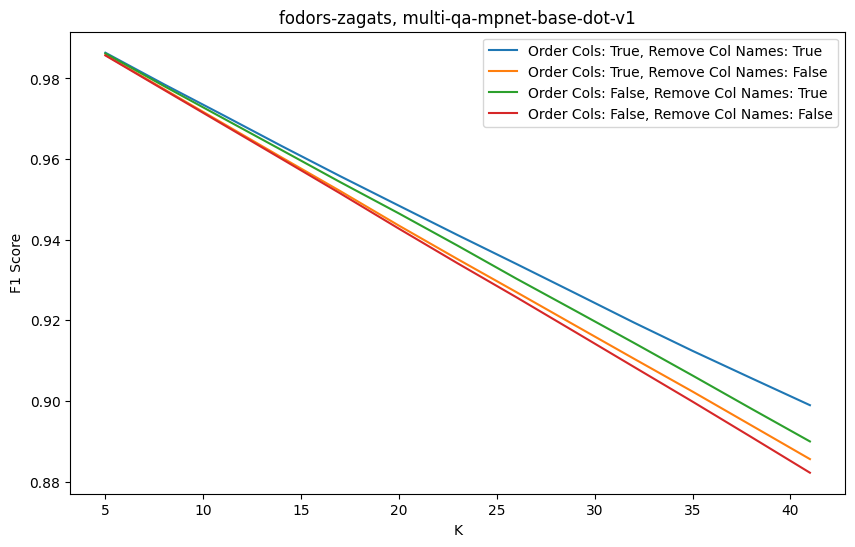

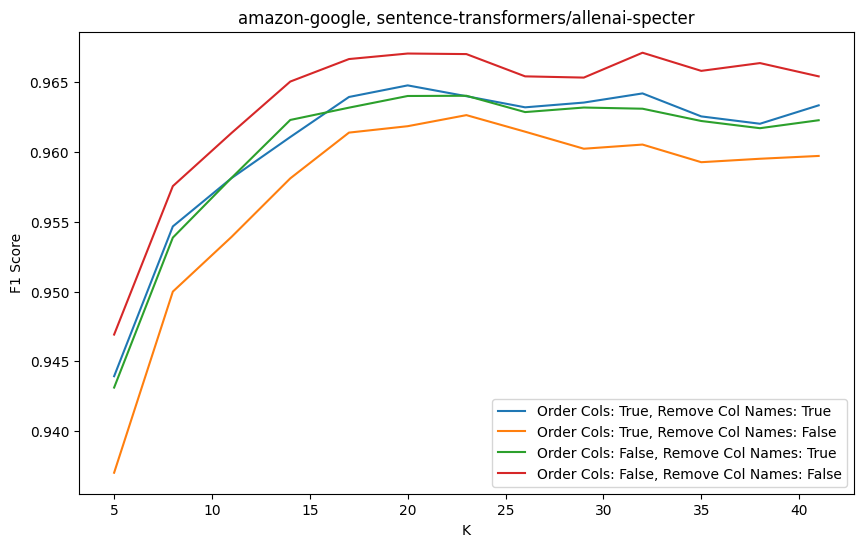

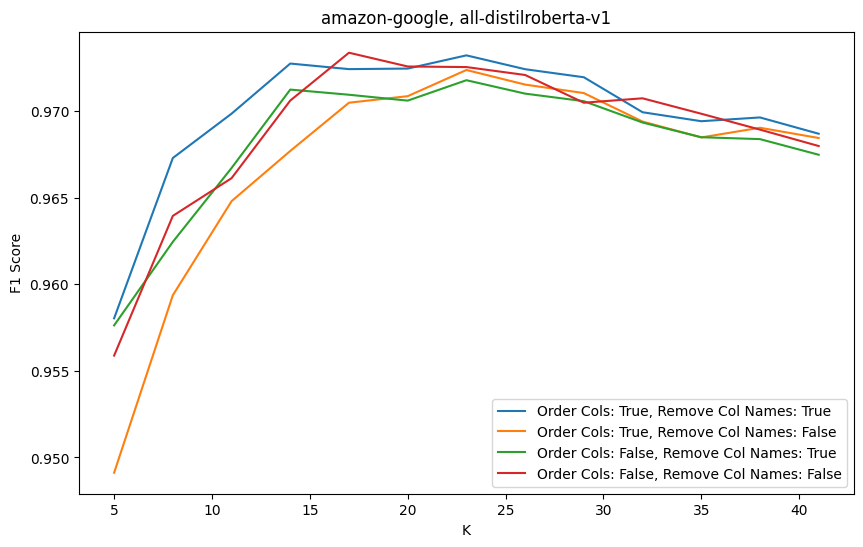

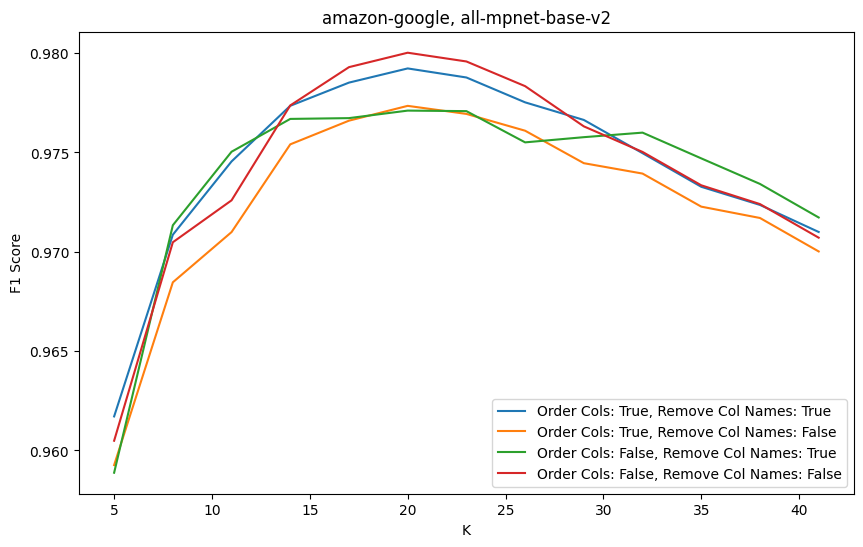

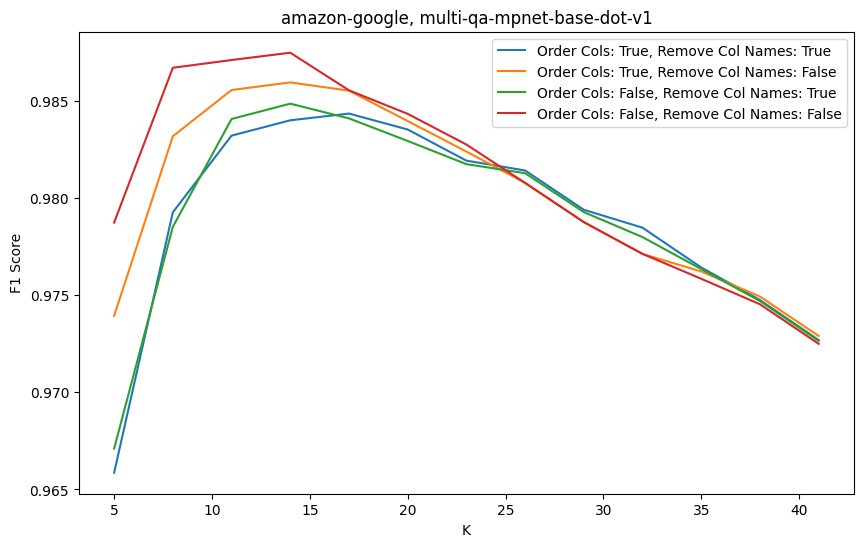

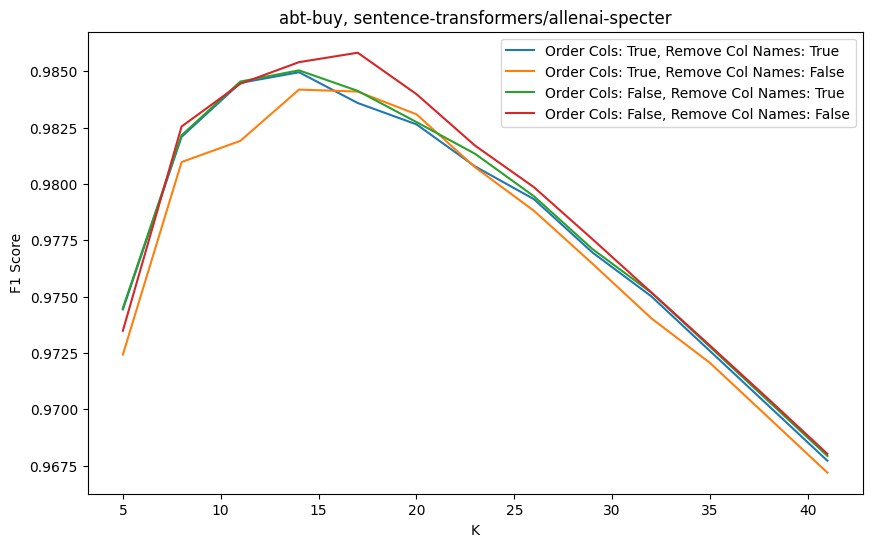

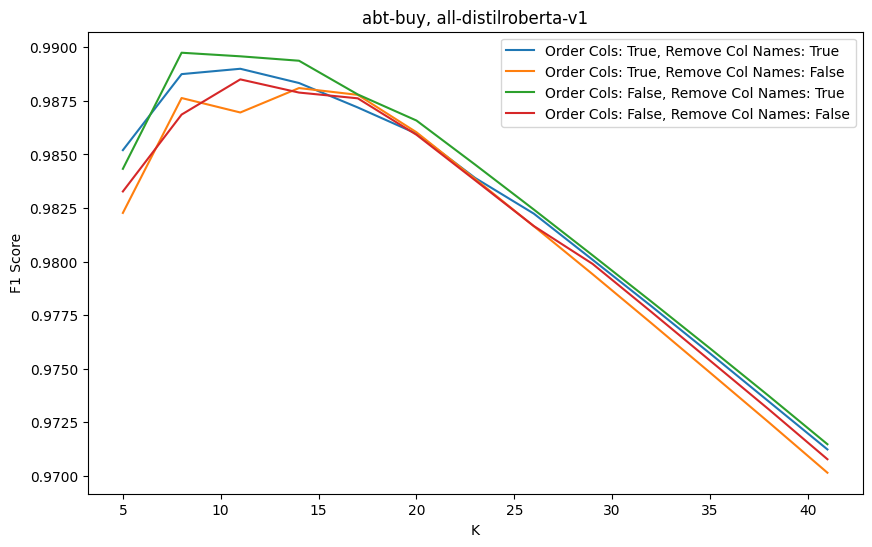

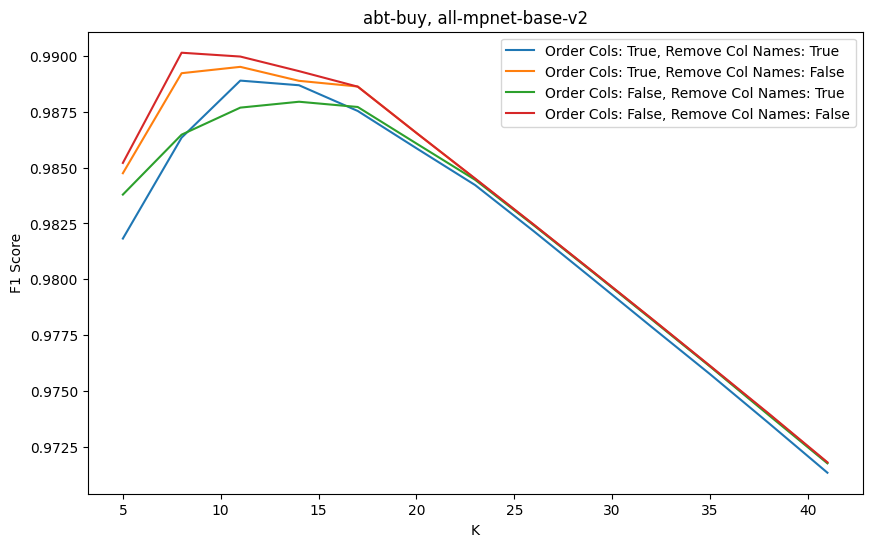

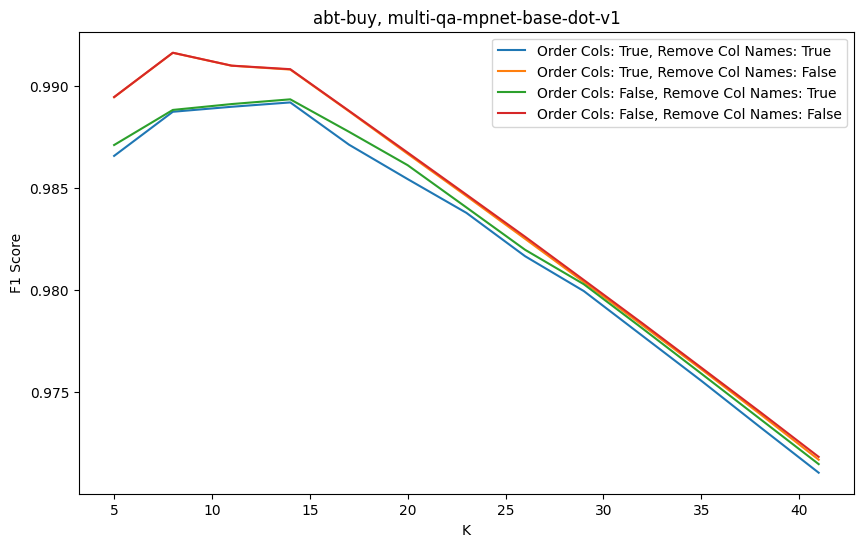

In [41]:
for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        plt.figure(figsize=(10, 6))
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                Ks = list(metrics.keys())
                f1s = [metrics[K]['f1'] for K in Ks]
                plt.plot(Ks, f1s, label=f'Order Cols: {order_cols}, Remove Col Names: {remove_col_names}')
        plt.title(f'{data_name}, {model_name}')
        plt.xlabel('K')
        plt.ylabel('F1 Score')
        plt.legend()
        
plt.show()

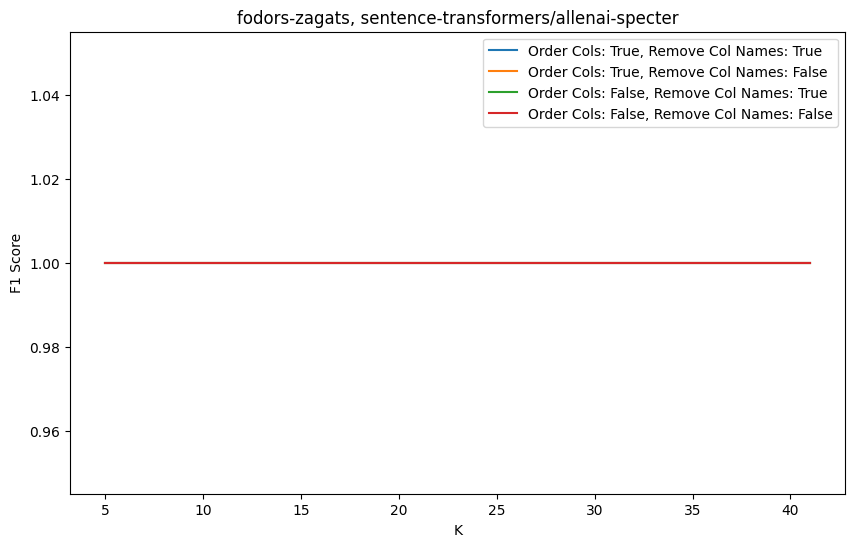

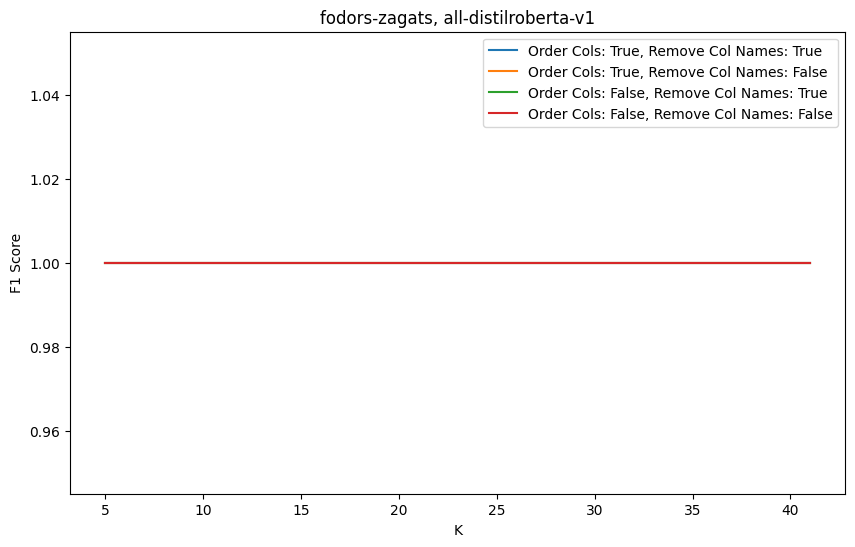

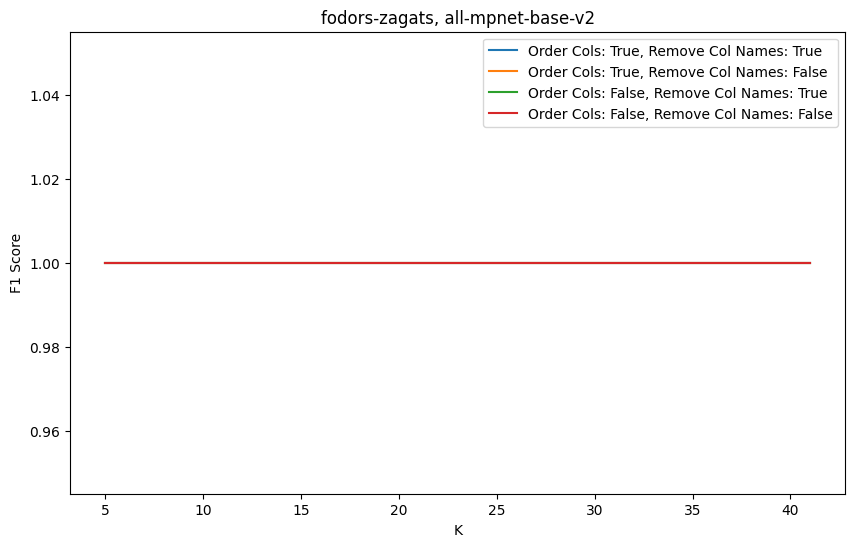

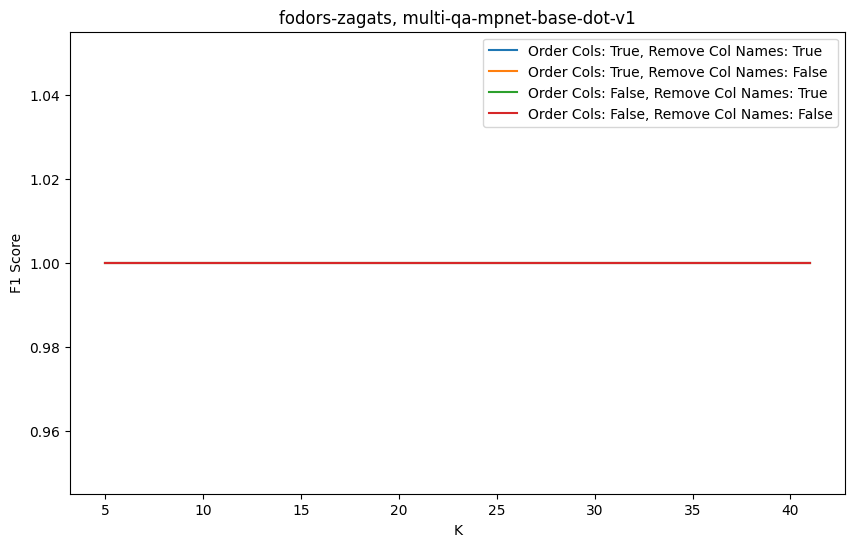

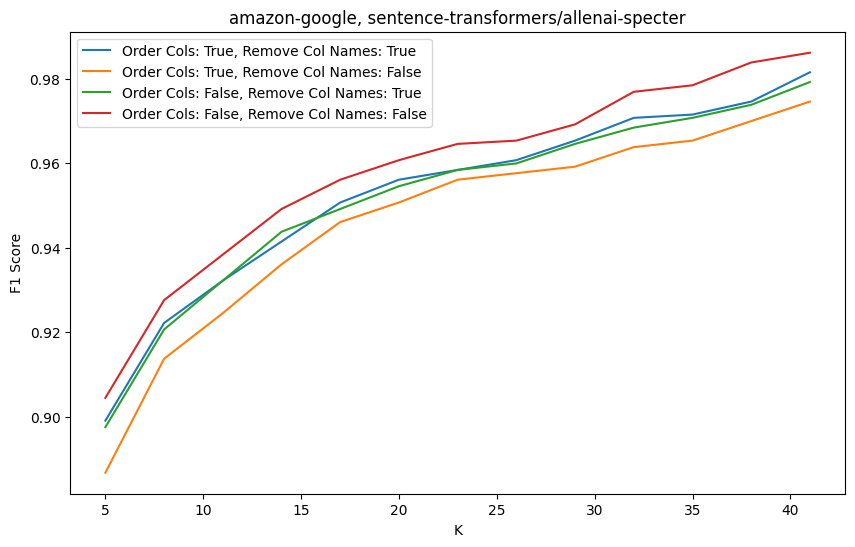

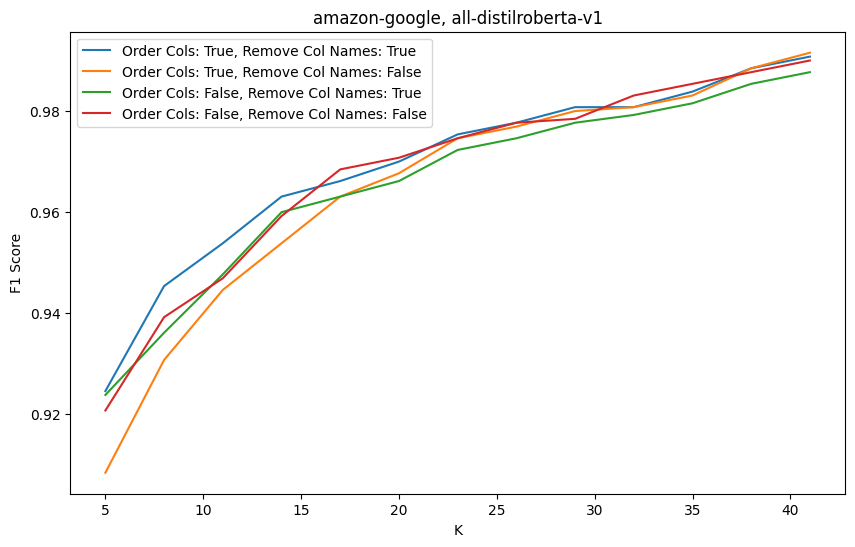

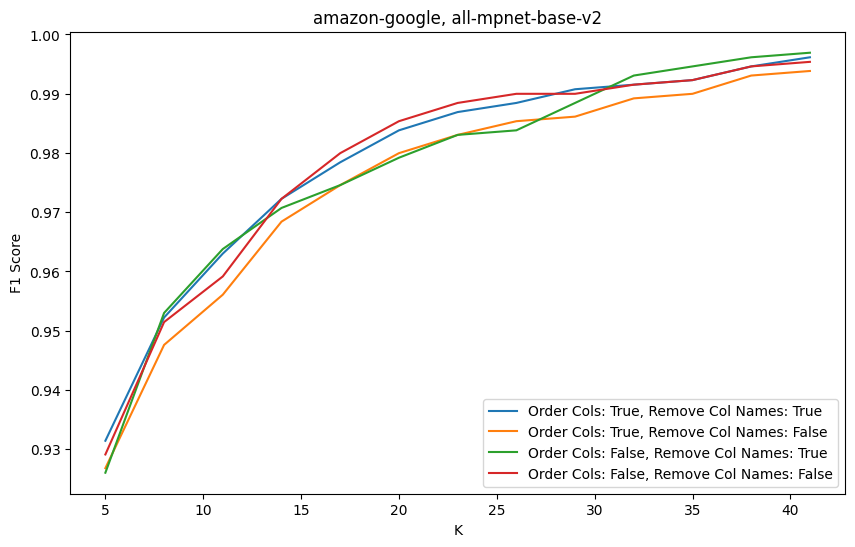

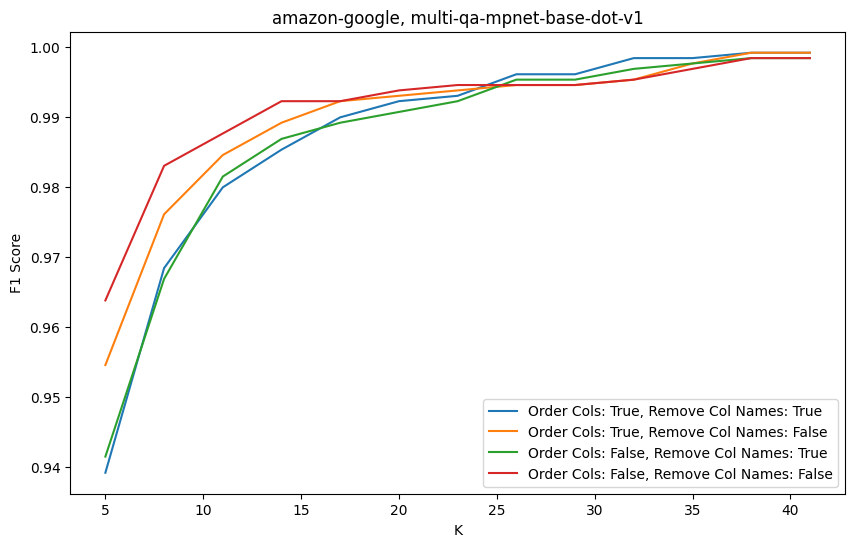

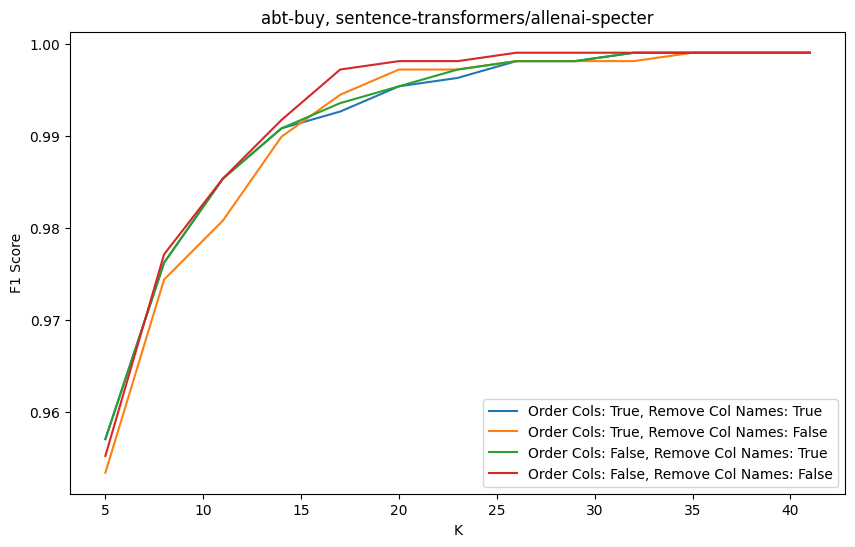

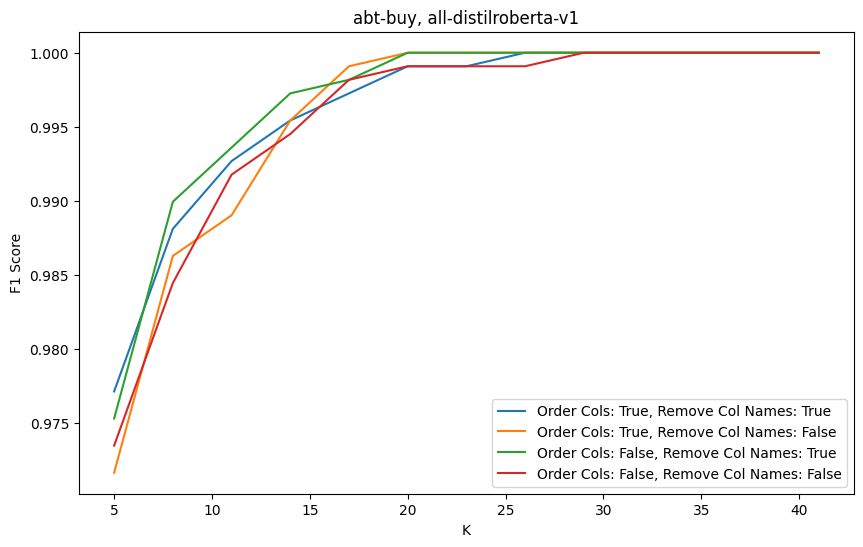

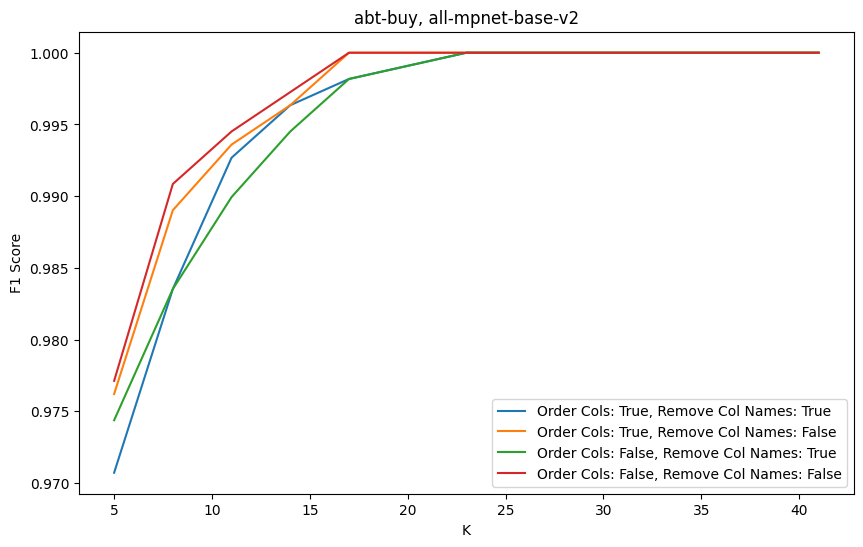

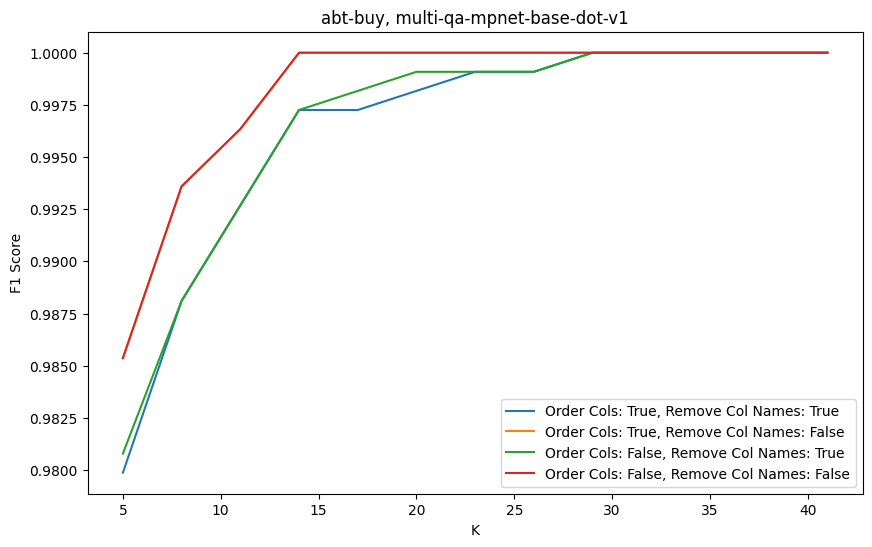

In [42]:
for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        plt.figure(figsize=(10, 6))
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                Ks = list(metrics.keys())
                f1s = [metrics[K]['recall'] for K in Ks]
                plt.plot(Ks, f1s, label=f'Order Cols: {order_cols}, Remove Col Names: {remove_col_names}')
        plt.title(f'{data_name}, {model_name}')
        plt.xlabel('K')
        plt.ylabel('F1 Score')
        plt.legend()
        
plt.show()

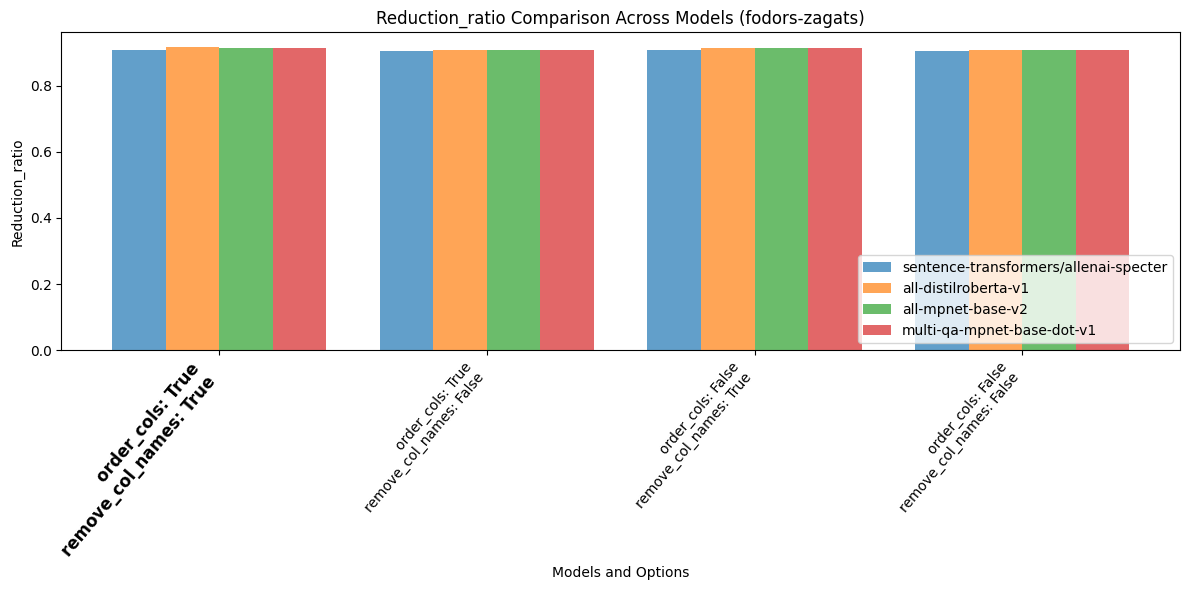

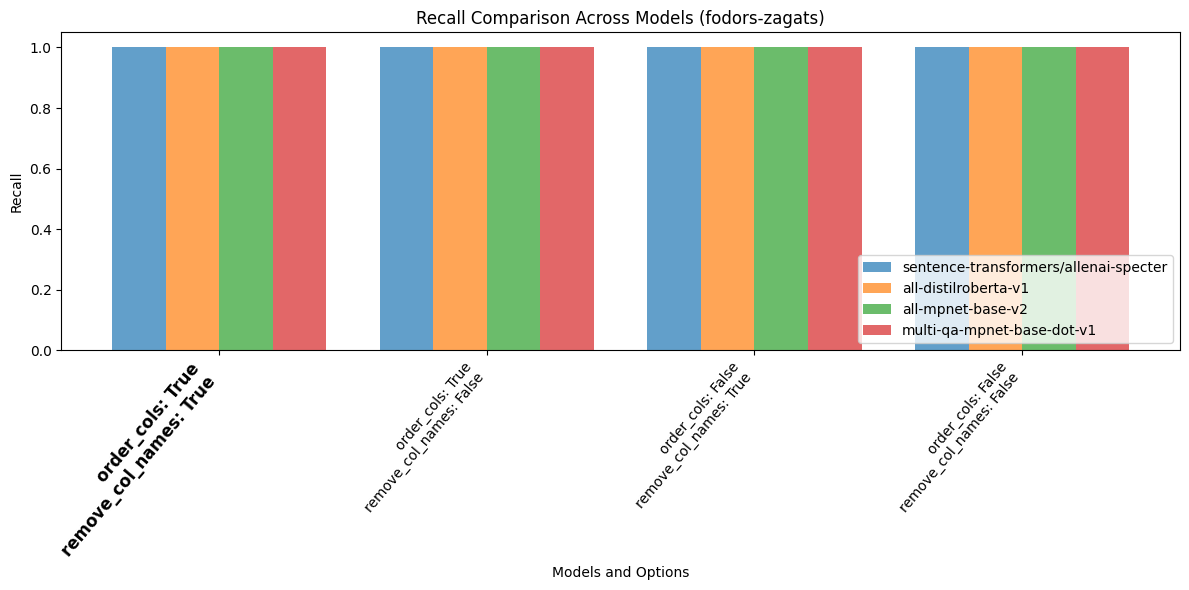

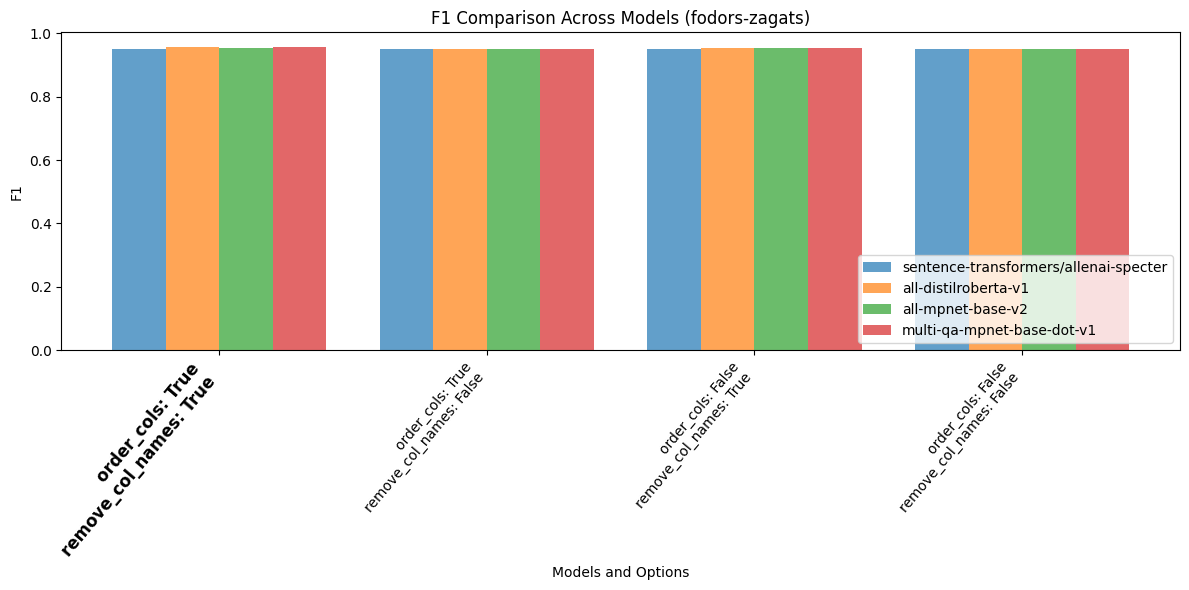

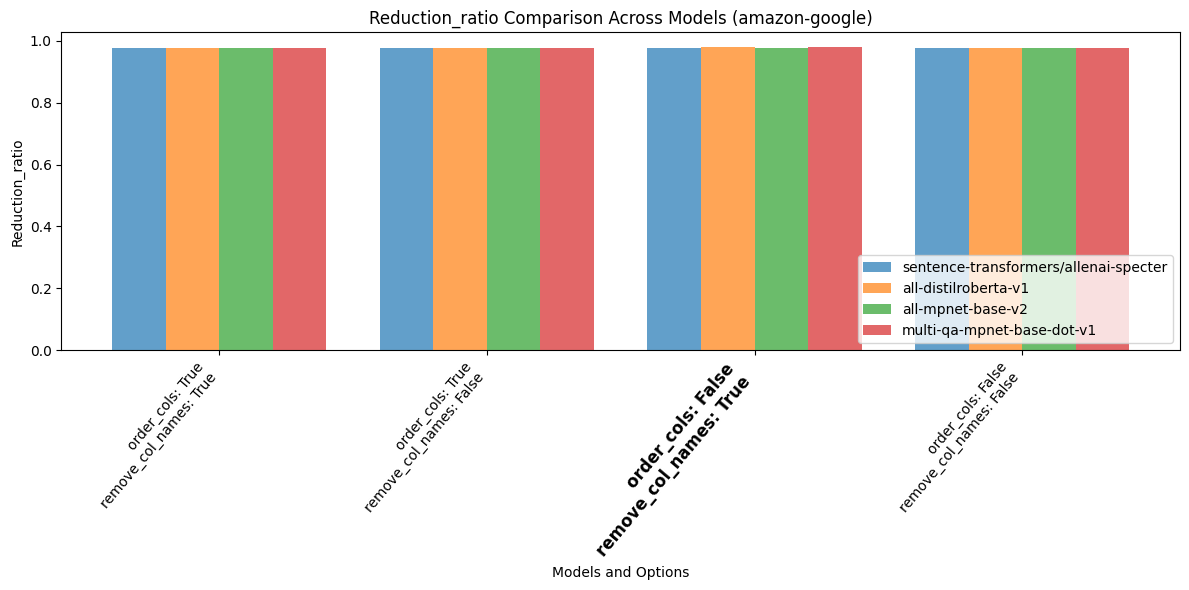

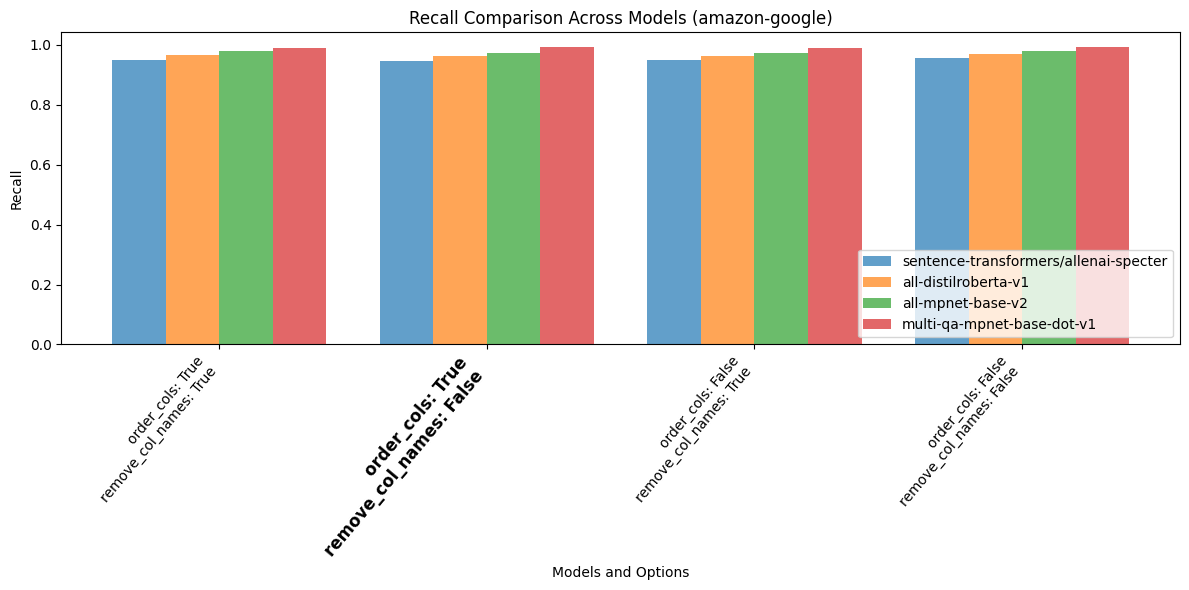

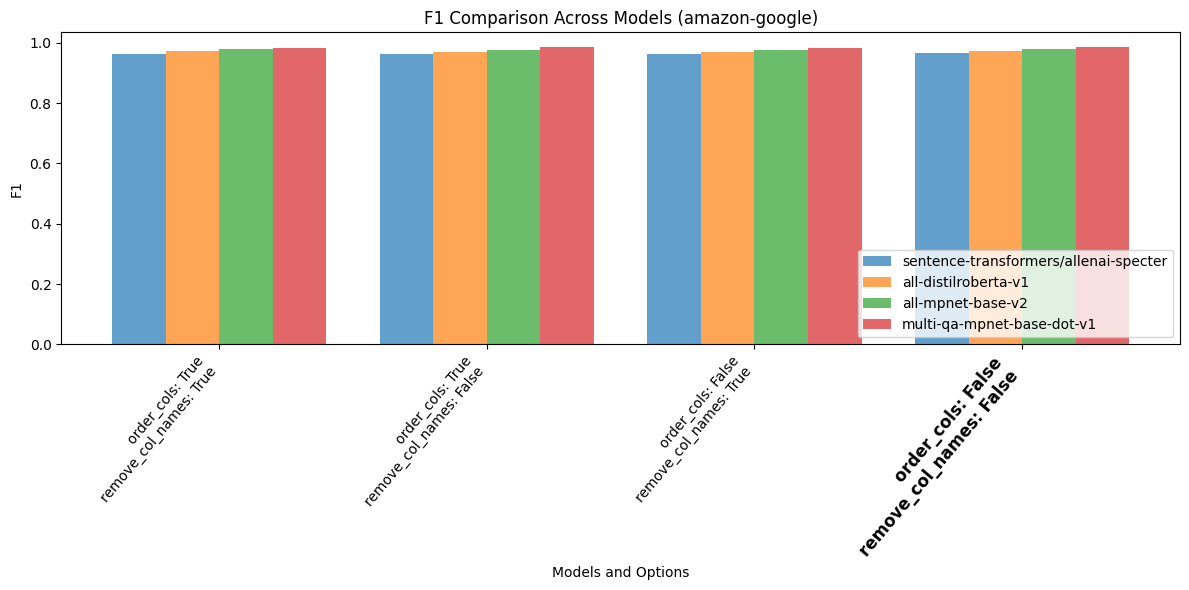

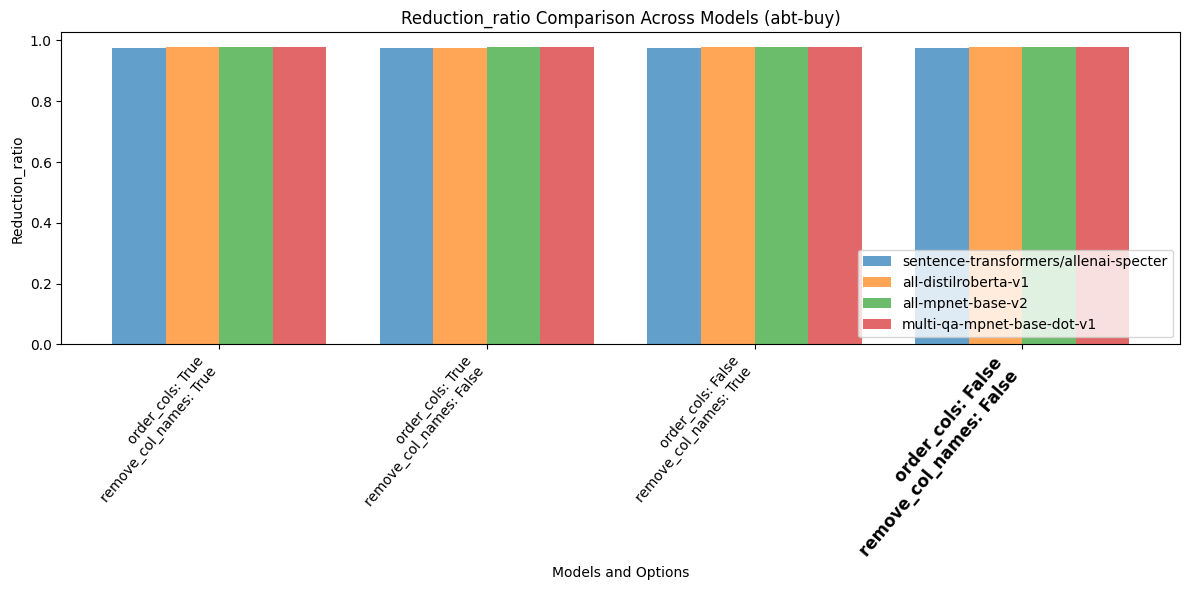

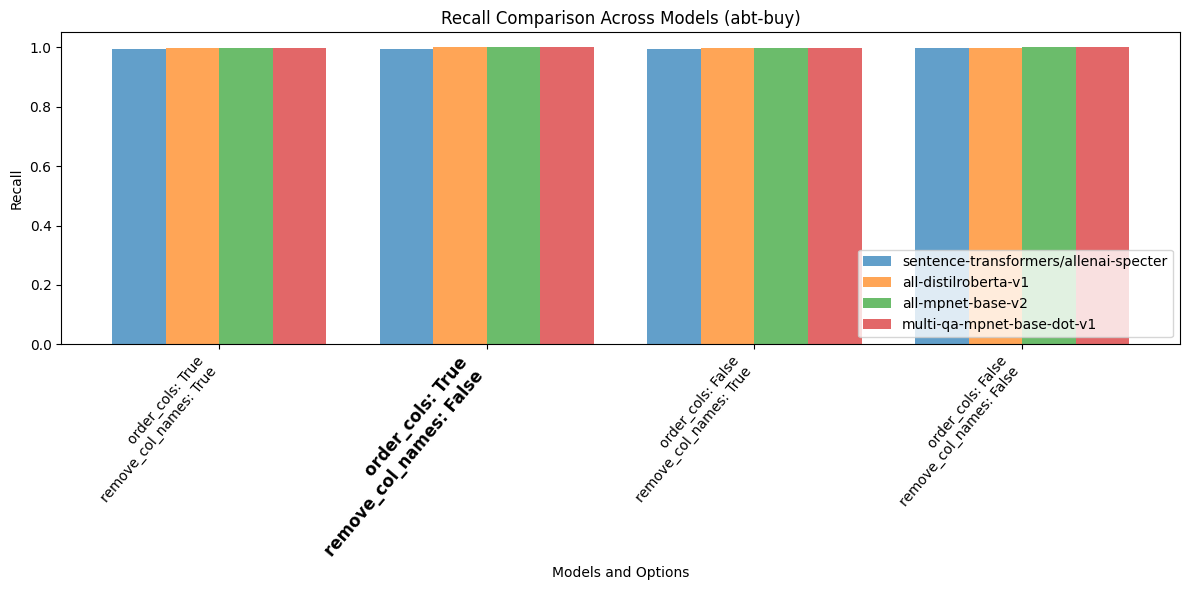

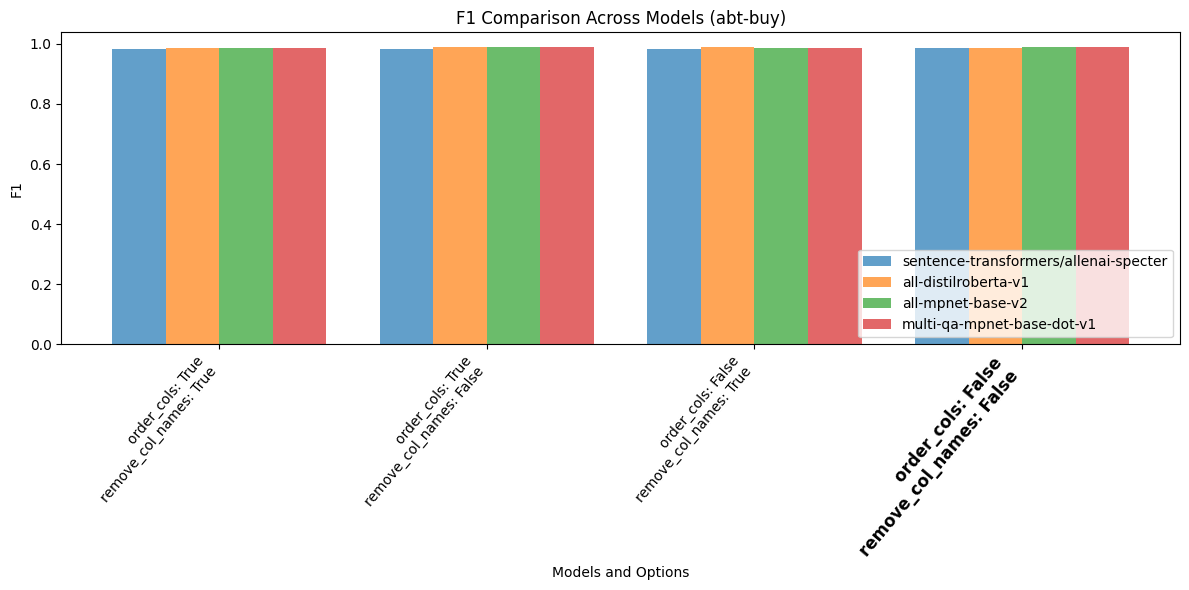

In [44]:
import numpy as np

import matplotlib.pyplot as plt

# Extracting data
metrics_list = ['reduction_ratio', 'recall', 'f1']
datasets = results_dict.keys()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
K = 17

for data_name in datasets:
    for metric in metrics_list:
        fig, ax = plt.subplots(figsize=(12, 6))
        model_names = list(results_dict[data_name].keys())
        num_models = len(model_names)
        values = [[] for _ in range(num_models)]
        labels = []
        color_map = []
        for model_idx, model_name in enumerate(model_names):
            for order_cols in results_dict[data_name][model_name].keys():
                for remove_col_names in results_dict[data_name][model_name][order_cols].keys():
                    if model_idx == 0:
                        labels.append(f"order_cols: {order_cols}\nremove_col_names: {remove_col_names}")
                    values[model_idx].append(results_dict[data_name][model_name][order_cols][remove_col_names][K].get(metric, np.nan))
                    color_map.append(colors[model_idx % len(colors)])
        
        x = np.arange(len(labels))
        bar_width = 0.8 / num_models  # Adjust the width of the bars
        for i in range(num_models):
            ax.bar(x + i * bar_width, values[i], bar_width, color=colors[i % len(colors)], alpha=0.7, label=model_names[i])
        
        ax.set_xticks(x + bar_width * (num_models - 1) / 2)
        ax.set_xticklabels(labels, rotation=50, ha='right')
        ax.set_title(f"{metric.capitalize()} Comparison Across Models ({data_name})")
        ax.set_xlabel("Models and Options")
        ax.set_ylabel(metric.capitalize())
        ax.legend(loc='lower right')
        
        # Highlight the best option
        try:
            best_option_idx = np.nanargmax([max(values[i]) for i in range(num_models)])
            best_label_idx = np.nanargmax(values[best_option_idx])
            ax.get_xticklabels()[best_label_idx].set_fontweight('bold')
            ax.get_xticklabels()[best_label_idx].set_fontsize(12)
        except ValueError:
            pass  # Handle the case where all values are NaN
        
        plt.tight_layout()
        plt.show()